done
tf.Tensor(
[[[[ 1.17933750e-03]
   [ 3.26716900e-03]
   [ 4.13465500e-03]
   [ 6.69229031e-03]
   [-5.72061539e-03]
   [ 1.12324953e-02]
   [ 5.86032867e-04]
   [ 4.40406799e-03]
   [ 3.67844105e-03]
   [ 4.92417812e-03]
   [-2.58868933e-03]
   [ 1.25802755e-02]
   [ 6.57224655e-03]
   [ 5.28395176e-03]
   [-1.81323290e-03]
   [ 2.00784206e-03]
   [-4.70763445e-03]
   [-3.48198414e-03]
   [-1.98280811e-03]
   [-5.24938107e-03]
   [-1.11978054e-02]
   [ 8.17608833e-03]
   [-2.19267607e-03]
   [ 6.43730164e-05]
   [-7.35527277e-03]
   [ 4.32026386e-03]
   [-1.43095851e-02]
   [-3.82423401e-03]]

  [[-4.28384542e-03]
   [-1.23631954e-03]
   [ 2.04956532e-03]
   [-2.86005139e-02]
   [-5.38170338e-04]
   [ 1.24673843e-02]
   [ 1.25426054e-02]
   [ 7.29596615e-03]
   [-5.35422564e-03]
   [-2.31671333e-03]
   [-1.78518295e-02]
   [ 2.07954645e-02]
   [-8.24999809e-03]
   [-5.43177128e-04]
   [-4.43851948e-03]
   [-1.72160864e-02]
   [-3.04877758e-04]
   [-1.09974146e-02]
   [ 2.55959034e

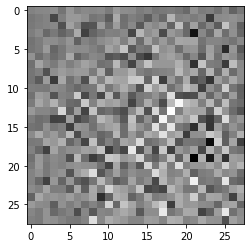

In [25]:
# coding: utf-8

import tensorflow as tf
with tf.device('/device:DML:0'):
    tf.enable_eager_execution()
# print(tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 加载数据集
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# 修改形状
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('f')
# 图片标准化 [-1, 1]
train_images = (train_images - 127.5) / 127.5

buffer_size = 60000
batch_size = 256
# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)


# 生成器
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)



print('done')
print(generated_image)
print(type(generated_image))
plt.imshow(generated_image.numpy()[0, :, :, 0], cmap='gray')

In [26]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00304364]], shape=(1, 1), dtype=float32)


In [35]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

#         display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # save every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print('Time for epoch {} is {}s'.format(epoch+1, time.time()-start))
        
#     display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [36]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10154166670050467589
, name: "/device:DML:0"
device_type: "DML"
memory_limit: 7615807488
locality {
}
incarnation: 545060736372591693
physical_device_desc: "{\"name\": \"NVIDIA GeForce RTX 2070\000\", \"vendor_id\": 4318, \"device_id\": 7938, \"driver_version\": \"27.21.14.7025\"}"
]


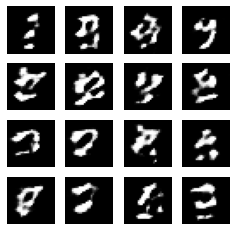

Time for epoch 1 is 11.789636373519897s


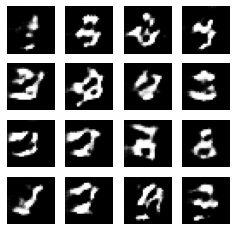

Time for epoch 2 is 10.228516817092896s


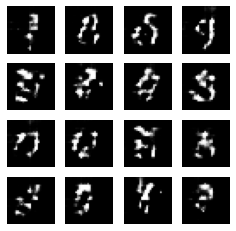

Time for epoch 3 is 10.29983925819397s


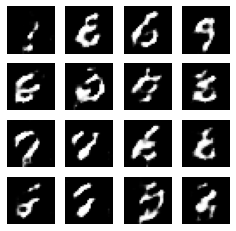

Time for epoch 4 is 10.278831481933594s


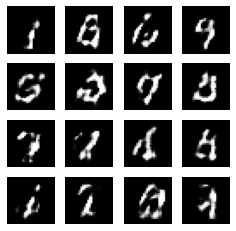

Time for epoch 5 is 10.412132501602173s


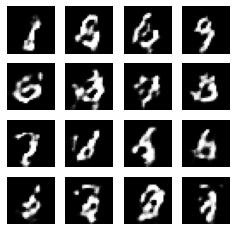

Time for epoch 6 is 10.341130256652832s


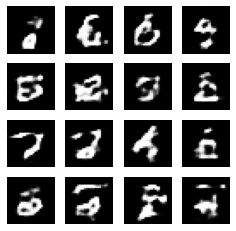

Time for epoch 7 is 10.444783449172974s


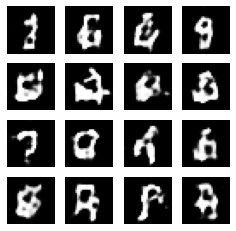

Time for epoch 8 is 10.546741008758545s


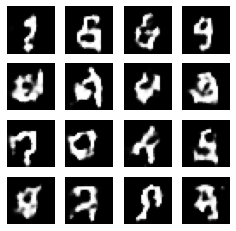

Time for epoch 9 is 10.465100765228271s


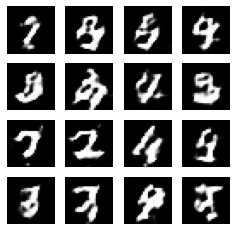

Time for epoch 10 is 10.498217344284058s


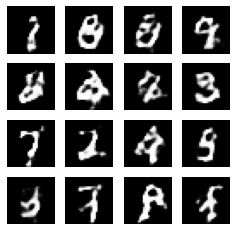

Time for epoch 11 is 10.594526052474976s


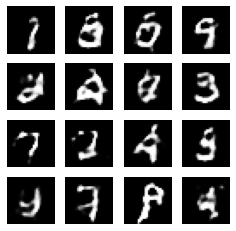

Time for epoch 12 is 10.484147787094116s


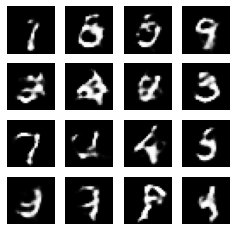

Time for epoch 13 is 10.556888341903687s


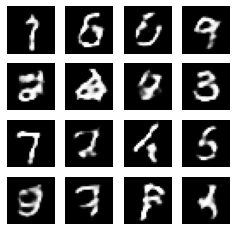

Time for epoch 14 is 10.49213719367981s


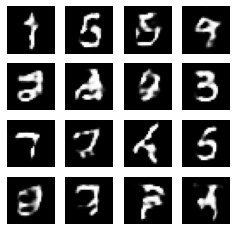

Time for epoch 15 is 10.598583698272705s


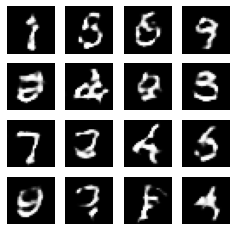

Time for epoch 16 is 10.60915470123291s


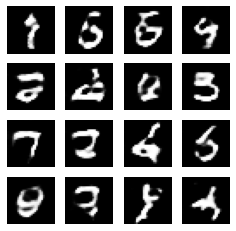

Time for epoch 17 is 10.516681671142578s


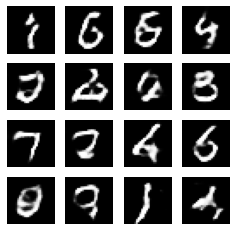

Time for epoch 18 is 10.535004615783691s


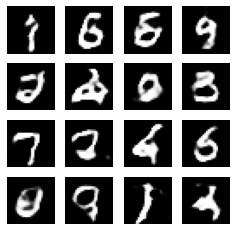

Time for epoch 19 is 10.630755186080933s


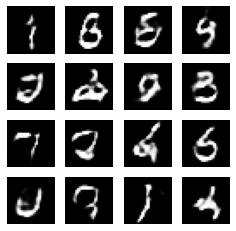

Time for epoch 20 is 10.539190530776978s


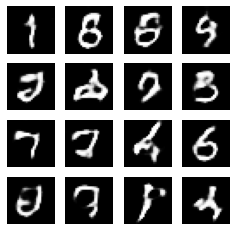

Time for epoch 21 is 10.540083408355713s


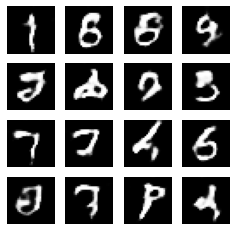

Time for epoch 22 is 10.643945217132568s


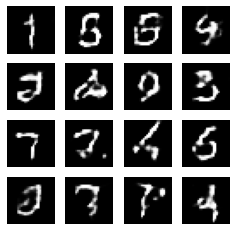

Time for epoch 23 is 10.572185277938843s


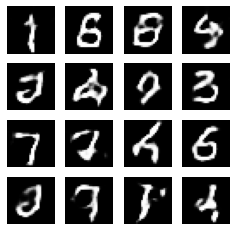

Time for epoch 24 is 10.691868782043457s


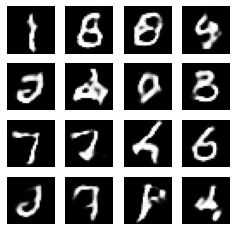

Time for epoch 25 is 10.733054637908936s


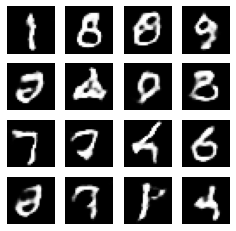

Time for epoch 26 is 10.568030595779419s


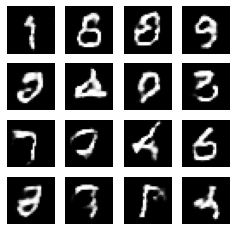

Time for epoch 27 is 10.662363529205322s


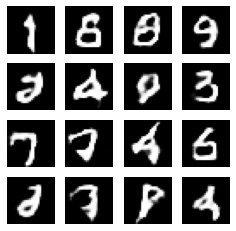

Time for epoch 28 is 10.5703763961792s


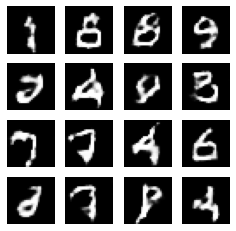

Time for epoch 29 is 10.571493148803711s


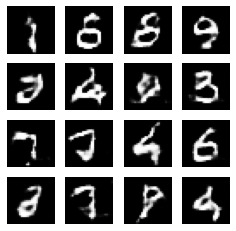

Time for epoch 30 is 10.74118161201477s


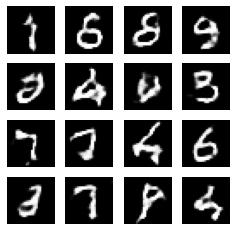

Time for epoch 31 is 10.57868242263794s


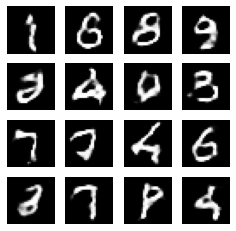

Time for epoch 32 is 10.596125602722168s


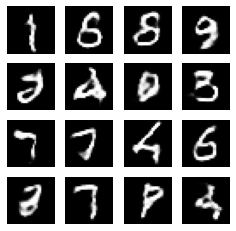

Time for epoch 33 is 10.672644138336182s


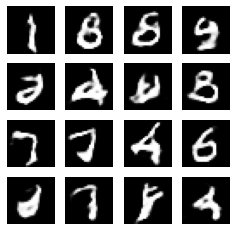

Time for epoch 34 is 10.578645944595337s


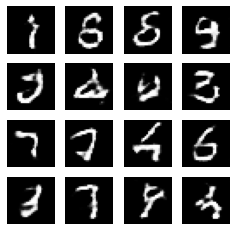

Time for epoch 35 is 10.590039491653442s


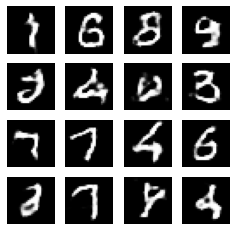

Time for epoch 36 is 10.693492650985718s


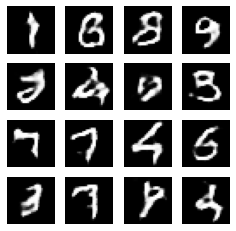

Time for epoch 37 is 10.59118938446045s


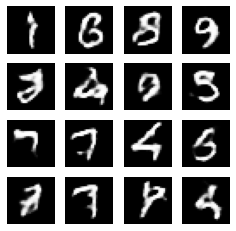

Time for epoch 38 is 10.738470554351807s


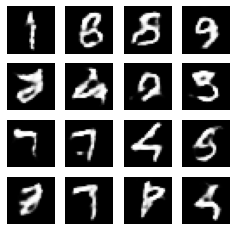

Time for epoch 39 is 10.600911378860474s


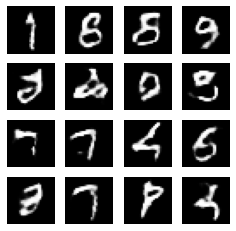

Time for epoch 40 is 10.640156030654907s


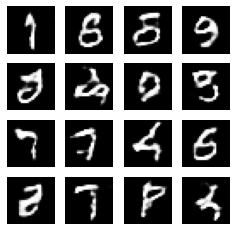

Time for epoch 41 is 10.722894191741943s


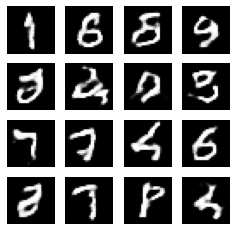

Time for epoch 42 is 10.631922006607056s


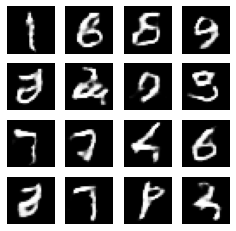

Time for epoch 43 is 10.673790693283081s


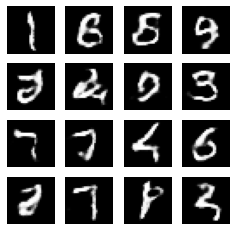

Time for epoch 44 is 10.74168872833252s


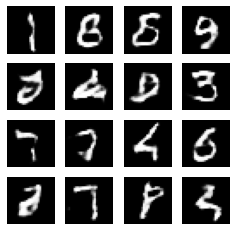

Time for epoch 45 is 10.706568002700806s


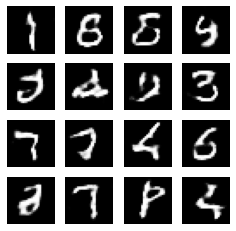

Time for epoch 46 is 10.639662742614746s


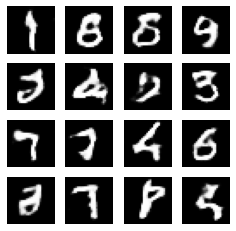

Time for epoch 47 is 10.730607748031616s


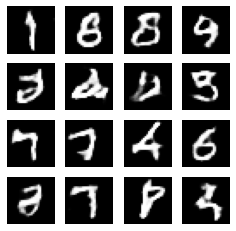

Time for epoch 48 is 10.642146825790405s


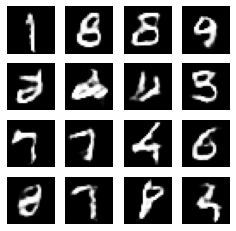

Time for epoch 49 is 10.73945665359497s


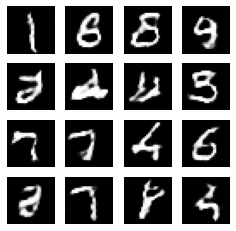

Time for epoch 50 is 10.651631593704224s


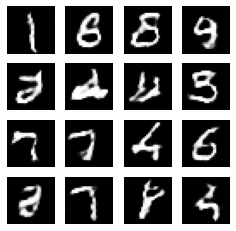

In [37]:
with tf.device('/device:DML:0'):
    train(train_dataset, epochs)

In [29]:
tf.test.is_gpu_available()

True